In [1]:
import torch
import numpy as np
import torch.nn as nn

import matplotlib.pyplot as plt
import sys
import os

sys.path.append("../scripts")

from network import KoopmanNet
from dataset import KoopmanDatasetCollector

pybullet build time: Jan 29 2025 23:16:28
/home/yuyang-pang/miniconda3/envs/koopman/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def cov_loss(net, x):
    z = net.encode(x)
    z_mean = torch.mean(z, dim=0, keepdim=True)
    z_centered = z - z_mean
    cov_matrix = (z_centered.t() @ z_centered) / (z_centered.size(0) - 1)
    diag_cov = torch.diag(torch.diag(cov_matrix))
    off_diag = cov_matrix - diag_cov
    loss = torch.norm(off_diag, p='fro')**2
    return loss.detach().cpu().numpy()

def Klinear_loss(data, net, u_dim):
    steps, train_traj_num, N = data.shape
    if u_dim is None:
        state_dim = N
    else:
        state_dim = N - u_dim

    mse_loss = nn.MSELoss()

    pred_state_mse_list = []
    
    if u_dim is None:
        Z_current = net.encode(data[0, :])        

        for i in range(steps - 1):
            Z_next_pred = net.forward(Z_current, None)

            pred_state = Z_next_pred[:, :state_dim]
            true_state = data[i+1, :]
            mse_state = mse_loss(pred_state, true_state).detach().cpu().numpy()
            pred_state_mse_list.append(mse_state)

            Z_current = Z_next_pred

    else:
        Z_current = net.encode(data[0, :, u_dim:])

        for i in range(steps - 1):
            Z_next_pred = net.forward(Z_current, data[i, :, :u_dim])

            pred_state = Z_next_pred[:, :state_dim]
            true_state = data[i+1, :, u_dim:]
            mse_state = mse_loss(pred_state, true_state).detach().cpu().numpy()
            pred_state_mse_list.append(mse_state)

            Z_current = Z_next_pred

    return np.array(pred_state_mse_list)

In [57]:
def eval_err(env_name, encode_dim, cov_reg, seed=1, device="cuda"):
    Ksteps = 1 if env_name in ["Polynomial", "LogisticMap"] else 15
    data_path = f"../data/datasets/dataset_{env_name}_Ktrain_60000_Kval_20000_Ktest_20000_Ksteps_{Ksteps}.pt"
    data_collector = KoopmanDatasetCollector(env_name)
    if not os.path.exists(data_path):
        raise FileNotFoundError("Data file not found. Run train.py first.")

    data = torch.load(data_path, weights_only=False)
    test_data = torch.from_numpy(data["Ktest_data"]).to(device).double()
    u_dim = data_collector.u_dim
    state_dim = data_collector.state_dim


    dicts = torch.load(f'../log/best_models/best_model_{env_name}_{encode_dim}_{cov_reg}_{seed}.pth')
    state_dict = dicts['model']
    layer = dicts['layer']
    Nkoopman = layer[-1] + state_dim

    net = KoopmanNet(layer, Nkoopman,u_dim)
    net.load_state_dict(state_dict)
    net.to(device)
    net.double()
    net.eval()

    Kloss = Klinear_loss(test_data, net, u_dim)

    if u_dim is None:
        Closs = cov_loss(net, test_data[0, :])
    else:
        Closs = cov_loss(net, test_data[0, :, u_dim:])

    return Kloss, Closs


In [58]:
def plot_err(eval_err_dict, use_log=False):
    font = {'size': 12}
    plt.rc('font', **font)
    plt.figure(figsize=(12, 8))
    for label in eval_err_dict.keys():
        Kloss = eval_err_dict[label][0]
        title = label[0]
        label = 'Encode Dim: {}, c_loss: {}, seed: {}'.format(label[1],label[2],label[3])
        if use_log:
            plt.plot(np.log10(Kloss),'*-',label=label,linewidth=1.5)
        else:
            plt.plot(Kloss,'*-',label=label,linewidth=1.5)

    plt.legend()
    plt.title(title)
    plt.xlabel('Steps')
    plt.ylabel('Error')
    plt.grid()
    plt.tight_layout()
    plt.show()

def plot_cov_loss(eval_err_dict, use_log=False):
    cov_losses = []
    encode_dims = []
    for label in eval_err_dict.keys():
        cov_loss = eval_err_dict[label][1]
        encode_dim = label[1]
        cov_losses.append(cov_loss)
        encode_dims.append(encode_dim)

    plt.figure(figsize=(12, 8))
    plt.plot(encode_dims, cov_losses, '*-', linewidth=1.5)
    plt.title('Covariance Loss')
    plt.xlabel('Encode Dim')
    plt.ylabel('Loss')
    plt.grid()
    plt.tight_layout()
    plt.show()

In [95]:
env_name = "Go2"
encode_dims = [1, 4, 16, 64, 256, 512, 1024]
cov_regs = [0, 1]

eval_err_dict = {}

for encode_dim in encode_dims:
    for cov_reg in cov_regs:
        for i in range(1):
            eval_err_dict[(env_name, encode_dim, cov_reg, i+1)] = eval_err(env_name, encode_dim, cov_reg, i+1)

In [96]:
eval_err_dict_reg_loss = {}
eval_err_dict_no_reg_loss = {}

for key in eval_err_dict.keys():
    if key[2] == 0:
        eval_err_dict_no_reg_loss[key] = eval_err_dict[key]
    else:
        eval_err_dict_reg_loss[key] = eval_err_dict[key]

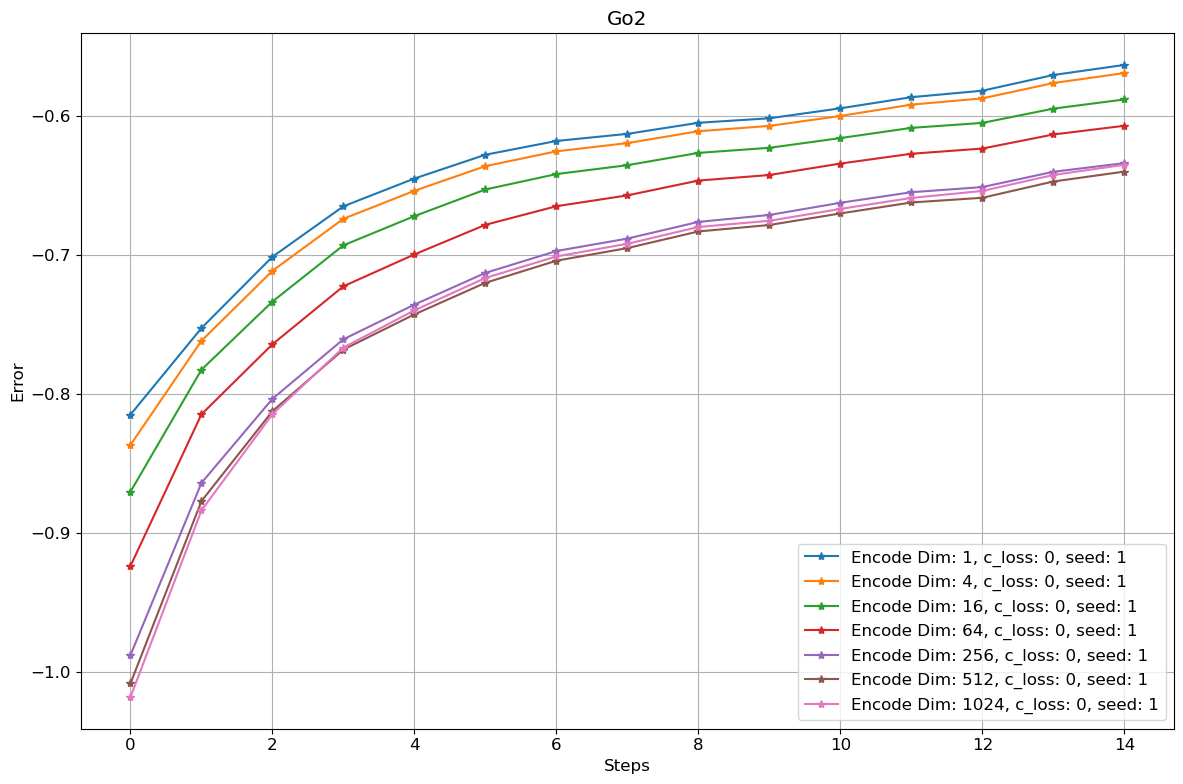

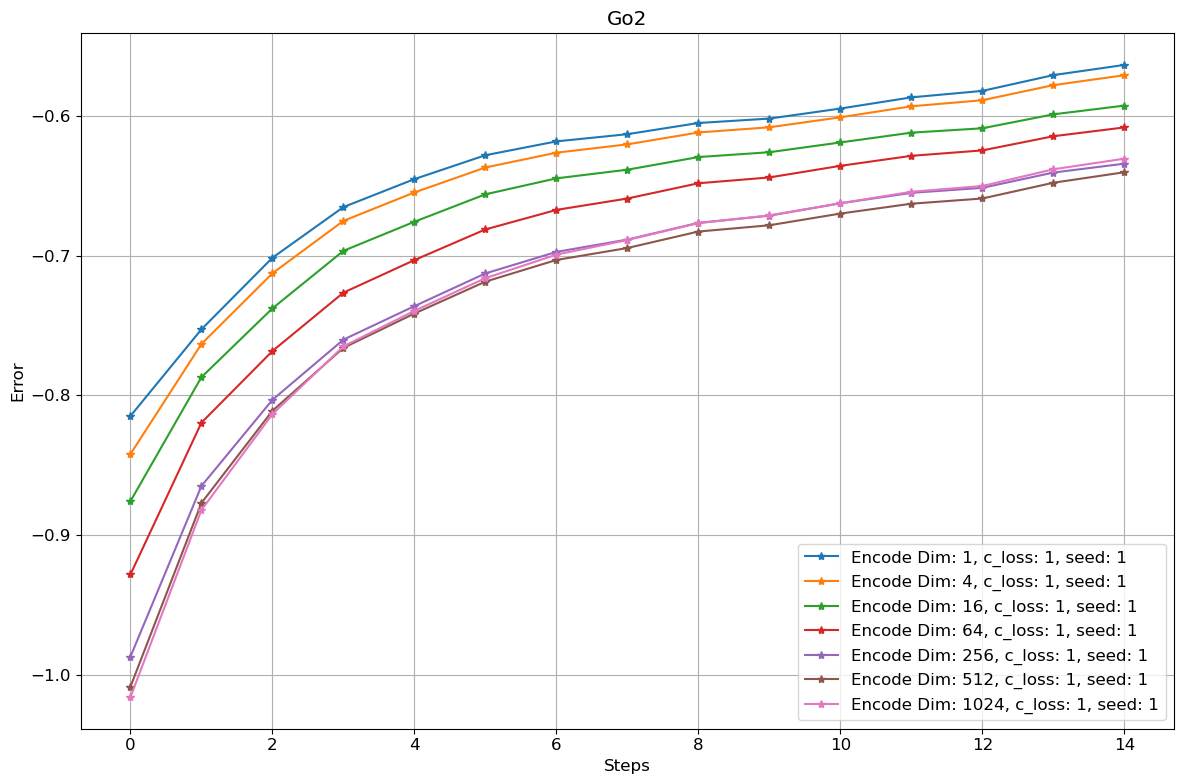

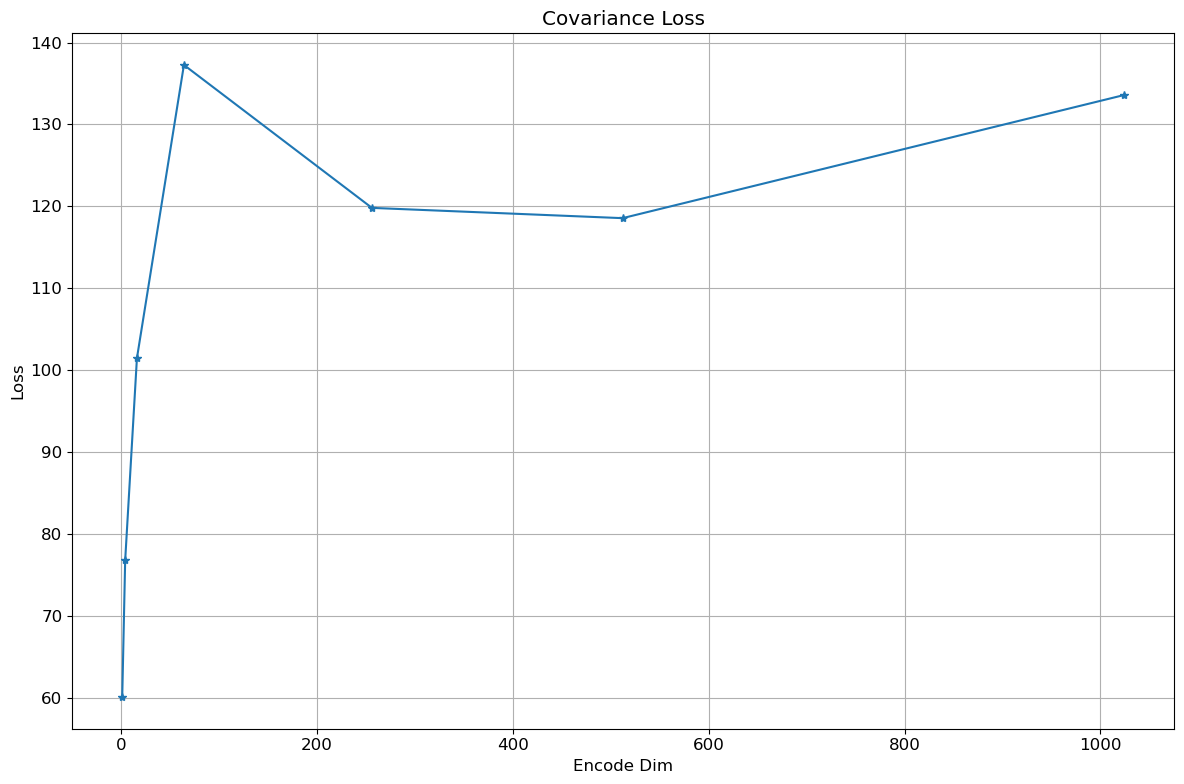

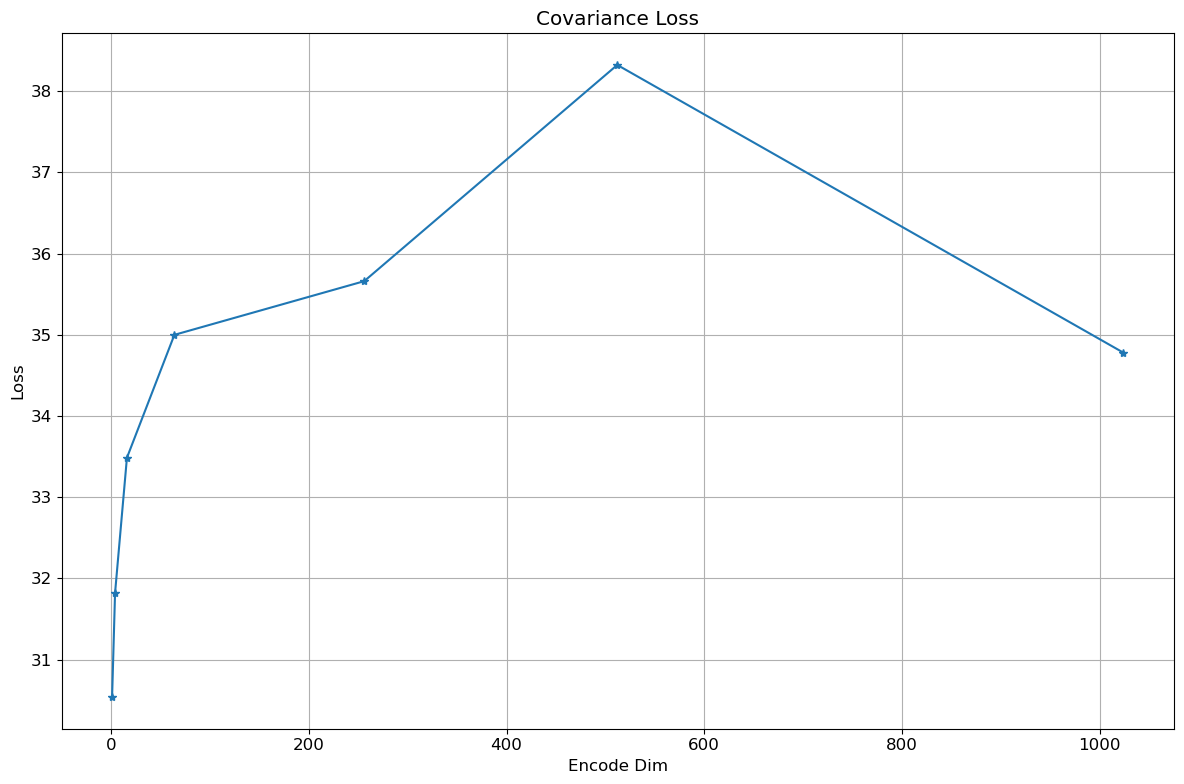

In [97]:
plot_err(eval_err_dict_no_reg_loss, use_log=True)
plot_err(eval_err_dict_reg_loss, use_log=True)
plot_cov_loss(eval_err_dict_no_reg_loss, use_log=False)
plot_cov_loss(eval_err_dict_reg_loss, use_log=False)


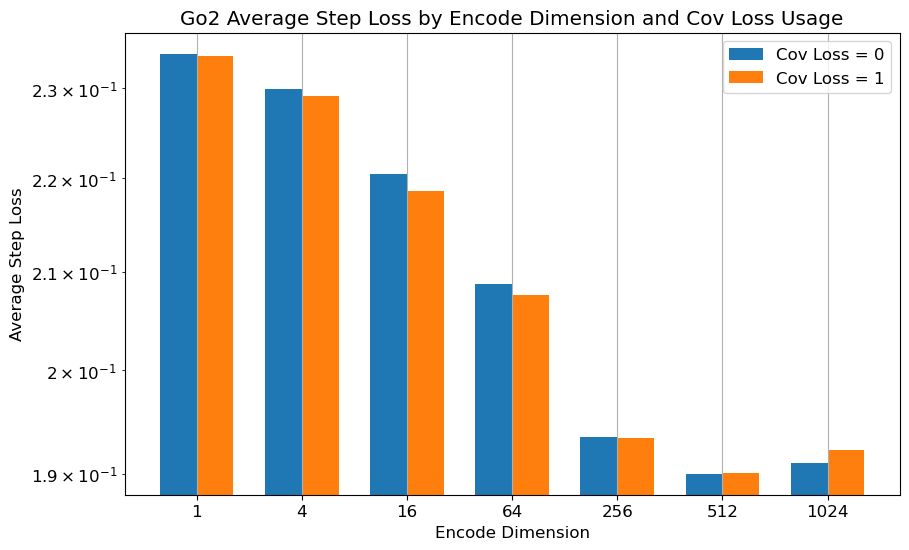

In [98]:
results_dict = eval_err_dict

grouped_losses = {}
for key, (step_losses, cov_loss_value) in results_dict.items():
    _, encode_dim, cov_flag, _ = key
    avg_step_loss = np.mean(step_losses)
    if encode_dim not in grouped_losses:
        grouped_losses[encode_dim] = {0: [], 1: []}
    grouped_losses[encode_dim][cov_flag].append(avg_step_loss)

avg_losses = {}
for encode_dim in sorted(grouped_losses.keys()):
    avg_losses[encode_dim] = {
        0: np.mean(grouped_losses[encode_dim][0]) if grouped_losses[encode_dim][0] else None,
        1: np.mean(grouped_losses[encode_dim][1]) if grouped_losses[encode_dim][1] else None,
    }

encode_dims = sorted(avg_losses.keys())
cov0_means = [avg_losses[d][0] for d in encode_dims]
cov1_means = [avg_losses[d][1] for d in encode_dims]

x = np.arange(len(encode_dims))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, cov0_means, width, label='Cov Loss = 0')
rects2 = ax.bar(x + width/2, cov1_means, width, label='Cov Loss = 1')

ax.set_xlabel("Encode Dimension")
ax.set_ylabel("Average Step Loss")
ax.set_title(f"{env_name} Average Step Loss by Encode Dimension and Cov Loss Usage")
ax.set_xticks(x)
ax.set_xticklabels(encode_dims)
ax.legend()
ax.grid(True)
ax.set_yscale('log')

plt.show()

